# NRL Team of the Year Analysis

Going to first determine which stats are most important to a teams win / loss record. Then we'll determine which players had the biggest impact on their team's success. Compare this to the 2018 Team of the Year to see if it's a fair reflection of the statistical data

Team of the Year:
    Fullback - Roger Tuivasa-Sheck - Warriors
    Winger - Blake Ferguson - Roosters
    Centre - Joseph Leilua - Raiders
    Five-eighth - Cameron Munster - Storm
    Halfback - Luke Brooks - Wests Tigers
    Lock - Jason Taumalolo - Cowboys
    Second-rower - Josh Jackson - Bulldogs
    Prop - Andrew Fifita - Sharks
    Hooker - Damien Cook - Rabbitohs
    Interchange - Jazz Tevaga - Warriors

In [1]:
#Import Pandas
import pandas as pd

In [2]:
#Connect to database
import mysql.connector as sql

mydb = sql.connect(
  host="localhost",
  user="root",
  passwd="NYg1@nts",
  database="NRL_data"
)


In [3]:
#Function to easily create dataframes from SQL query results
def create_df(query):
    return pd.read_sql_query(query, con=mydb)

In [4]:
#Only want to analyze matches from the 2018 season
matches2018 = "SELECT * FROM Matches WHERE year(date) = '2018';"
matches2018 = create_df(matches2018)
matches2018.head()

,id,date,round,home_team_id,home_score,away_team_id,away_score,winner,is_draw,stadium_id,weather,url
0,1,2018-03-08,1,14,34,1,12,14,0,1,None,http://www.nrl.com/draw/nrl-premiership/2018/r...
1,2,2018-03-09,1,8,19,6,18,8,0,2,None,http://www.nrl.com/draw/nrl-premiership/2018/r...
2,3,2018-03-09,1,10,20,4,14,10,0,3,None,http://www.nrl.com/draw/nrl-premiership/2018/r...
3,4,2018-03-10,1,16,10,15,8,16,0,4,None,http://www.nrl.com/draw/nrl-premiership/2018/r...
4,5,2018-03-10,1,13,20,9,32,9,0,5,None,http://www.nrl.com/draw/nrl-premiership/2018/r...


# Make Standings to have better idea of teams that performed well

In [5]:
#Better way to view the data in a table...easier to work with team names than ids
matches2018 = '''SELECT m.id, m.round, m.date,
CASE
	WHEN m.home_team_id = m.winner THEN home.nickname
    ELSE away.nickname
END winner,
CASE
	WHEN m.home_team_id = m.winner THEN m.home_score
    ELSE m.away_score
END winning_score,
CASE
	WHEN m.home_team_id = m.winner THEN away.nickname
    ELSE home.nickname
END loser,
CASE
	WHEN m.home_team_id = m.winner THEN m.away_score
    ELSE m.home_score
END losing_score, home.nickname home, away.nickname away
FROM Matches m
JOIN Teams home
ON m.home_team_id = home.id
JOIN Teams away
ON m.away_team_id = away.id
WHERE year(m.date) = 2018
ORDER BY date;'''
matches2018 = create_df(matches2018)
matches2018.head()

,id,round,date,winner,winning_score,loser,losing_score,home,away
0,1,1,2018-03-08,Dragons,34,Broncos,12,Dragons,Broncos
1,2,1,2018-03-09,Knights,19,Sea Eagles,18,Knights,Sea Eagles
2,3,1,2018-03-09,Cowboys,20,Sharks,14,Cowboys,Sharks
3,6,1,2018-03-10,Storm,36,Bulldogs,18,Bulldogs,Storm
4,5,1,2018-03-10,Warriors,32,Rabbitohs,20,Rabbitohs,Warriors


In [35]:
winners = matches2018.groupby('winner')
w_scored = winners['winning_score'].sum()
w_allowed = winners['losing_score'].sum()

losers = matches2018.groupby('loser')
l_scored = losers['losing_score'].sum()
l_allowed = losers['winning_score'].sum()

total_scores = pd.concat([w_scored, l_scored, w_allowed, l_allowed], axis=1, join='inner')
total_scores.columns = ['scored_in_win', 'scored_in_loss', 'allowed_in_win', 'allowed_in_loss']
total_scores.head(2)

total_scores['pts_scored'] = total_scores['scored_in_win'] + total_scores['scored_in_loss']
total_scores['pts_allowed'] = total_scores['allowed_in_win'] + total_scores['allowed_in_loss']
total_scores['pts_differential'] = total_scores['pts_scored'] - total_scores['pts_allowed']
total_points_data = total_scores[['pts_differential', 'pts_scored', 'pts_allowed']]
total_points_data.head()

,pts_differential,pts_scored,pts_allowed
Broncos,56,556,500
Bulldogs,-46,428,474
Cowboys,-72,449,521
Dragons,47,519,472
Eels,-176,374,550


In [7]:
#Pull win / loss records from database
standings2018 = '''SELECT t.nickname team,
    count(m.winner) as wins,
    24 - count(m.winner) as loses
FROM Matches m
JOIN Teams t
ON m.winner = t.id
WHERE year(m.date) = 2018
GROUP BY m.winner
ORDER BY wins DESC;'''
standings2018 = create_df(standings2018).set_index('team')
standings2018.head()

,wins,loses
team,,
Roosters,16,8
Rabbitohs,16,8
Storm,16,8
Sharks,16,8
Dragons,15,9


In [36]:
final_standings = pd.concat([standings2018, total_points_data], axis=1, join='inner').sort_values(['wins', 'pts_differential'], ascending=[0,0])
final_standings

,wins,loses,pts_differential,pts_scored,pts_allowed
Roosters,16,8,181,542,361
Storm,16,8,173,536,363
Rabbitohs,16,8,145,582,437
Sharks,16,8,96,519,423
Broncos,15,9,56,556,500
Panthers,15,9,56,517,461
Dragons,15,9,47,519,472
Warriors,15,9,25,472,447
Tigers,12,12,-83,377,460
Raiders,10,14,23,563,540


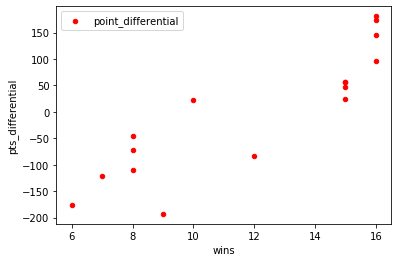

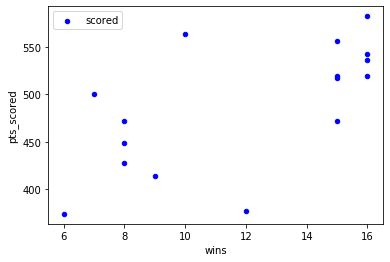

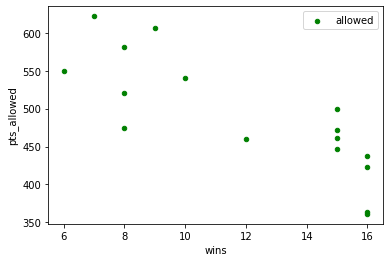

In [37]:
#From the standings above, we can see that points and 

final_standings.plot.scatter(x='wins', y='pts_differential', color='Red', label='point_differential')
final_standings.plot.scatter(x='wins', y='pts_scored', color='Blue', label='scored')
final_standings.plot.scatter(x='wins', y='pts_allowed', color='Green', label='allowed')

We can see correlation between point_differential and wins, but lets look at alternative metrics and player stats to find a better correlation to win probability.

# Want to see if there are any statistics that are a good predictor of wins

In [10]:
#PlayerMatchStats
query = '''SELECT CONCAT(p.first_name, ' ' ,p.last_name) name, t.nickname team, p_stats.*
        FROM PlayerMatchStats p_stats
        JOIN Players p
        ON p_stats.player_id = p.id
        JOIN Teams t
        ON p_stats.team_id = t.id
        JOIN Matches m
        ON p_stats.match_id = m.id
        WHERE year(m.date) = 2018;'''

player_stat_df = create_df(query)
player_stat_df.head()

,name,team,id,match_id,player_id,team_id,position_id,minutes_played,points,tries,...,kicked_dead,errors,handling_errors,one_on_ones_lost,penalties,on_report,sin_bins,send_offs,stint_one,stint_two
0,Darius Boyd,Broncos,18,1,22,1,1,80.0,0,0,...,0,1,1,0,0,0,0,0,80.0,None
1,Corey Oates,Broncos,19,1,20,1,2,80.0,0,0,...,0,1,1,0,0,0,0,0,80.0,None
2,James Roberts,Broncos,20,1,27,1,3,80.0,8,2,...,0,0,0,0,1,0,0,0,80.0,None
3,Jordan Kahu,Broncos,21,1,251,1,3,80.0,4,0,...,0,1,1,0,0,0,0,0,80.0,None
4,Jamayne Isaako,Broncos,22,1,26,1,2,80.0,0,0,...,0,2,0,0,0,0,0,0,80.0,None


In [11]:
#Look at columns...what can we drop and what can we alter?
player_stat_df.columns

Index(['name', 'team', 'id', 'match_id', 'player_id', 'team_id', 'position_id',
       'minutes_played', 'points', 'tries', 'conversions',
       'conversion_attempts', 'penalty_goals', 'conversion_percentage',
       'field_goals', 'total_runs', 'total_run_metres', 'kick_return_metres',
       'post_contact_metres', 'line_breaks', 'line_break_assists',
       'try_assists', 'line_engaged_runs', 'tackle_breaks', 'hit_ups',
       'play_the_ball', 'average_play_ball_seconds', 'dummy_half_runs',
       'dummy_half_run_metres', 'steals', 'offloads', 'dummy_passes', 'passes',
       'receipts', 'pass_to_run_ratio', 'tackle_percentage', 'tackles_made',
       'tackles_missed', 'ineffective_tackles', 'intercepts', 'kicks_defused',
       'kicks', 'kicking_metres', 'forced_drop_outs', 'bomb_kicks', 'grubbers',
       'fourty_twenty', 'cross_field_kicks', 'kicked_dead', 'errors',
       'handling_errors', 'one_on_ones_lost', 'penalties', 'on_report',
       'sin_bins', 'send_offs', 'stint_one'

In [12]:
player_stat_df = player_stat_df.drop(['id', 'team_id', 'conversions', 'conversion_attempts', 'penalty_goals', 'conversion_percentage',
                           'field_goals', 'hit_ups', 'play_the_ball', 'average_play_ball_seconds', 'dummy_half_runs',
                           'dummy_half_run_metres', 'steals', 'dummy_passes', 'receipts', 'pass_to_run_ratio',
                           'intercepts', 'kicks_defused', 'forced_drop_outs', 'bomb_kicks', 'grubbers', 'fourty_twenty',
                           'cross_field_kicks', 'kicked_dead', 'handling_errors', 'one_on_ones_lost', 'on_report',
                           'send_offs', 'stint_one', 'stint_two'], axis=1)
player_stat_df.head()

,name,team,match_id,player_id,position_id,minutes_played,points,tries,total_runs,total_run_metres,...,passes,tackle_percentage,tackles_made,tackles_missed,ineffective_tackles,kicks,kicking_metres,errors,penalties,sin_bins
0,Darius Boyd,Broncos,1,22,1,80.0,0,0,9,46,...,18,0.75,12,2,2,0,0,1,0,0
1,Corey Oates,Broncos,1,20,2,80.0,0,0,10,113,...,1,0.8,4,1,0,0,0,1,0,0
2,James Roberts,Broncos,1,27,3,80.0,8,2,7,48,...,10,0.786,11,1,2,0,0,0,1,0
3,Jordan Kahu,Broncos,1,251,3,80.0,4,0,5,50,...,0,0.783,18,5,0,0,0,1,0,0
4,Jamayne Isaako,Broncos,1,26,2,80.0,0,0,12,95,...,3,1.0,7,0,0,0,0,2,0,0


In [13]:
#grouped = player_df.groupby(['match_id', 'team']) 
#grouped.first()
player_stats2018 = player_stat_df.groupby(['player_id', 'name']).agg(sum)
player_stats2018.shape

(439, 24)

In [14]:
#Make Every Stat a per-minute stat
#grouped.loc[:,'points':'sin_bins'] = grouped.loc[:,'points':'sin_bins']apply()
#grouped.loc[:,'points':'sin_bins'] = grouped.loc[:,'points':'sin_bins'].div(grouped['minutes_played'], axis=0)
#grouped.sort_values(by=['kicking_metres'], ascending = 0)

In [39]:
team_stats = player_stat_df.groupby('team').agg(sum)
#team_stats['total_run_metres'].sort_values(ascending=False)
slimmed_team_stats = team_stats[['points', 'tries', 'total_runs', 'total_run_metres', 'tackles_made', 'tackles_missed', 'ineffective_tackles',
           'kicks', 'kicking_metres', 'errors', 'penalties']]
wins = final_standings[['wins', 'pts_differential', 'pts_scored', 'pts_allowed']]
wins_and_stats = pd.concat([wins, slimmed_team_stats], axis=1, join='inner').sort_values(['wins', 'pts_differential'], ascending=[0,0])
wins_and_stats['metres_per_kick'] = wins_and_stats['kicking_metres'] / wins_and_stats['kicks']
wins_and_stats['metres_per_run'] = wins_and_stats['total_run_metres'] / wins_and_stats['total_runs']
wins_and_stats['tackle_percentage'] = wins_and_stats['tackles_made'] / (wins_and_stats[['tackles_made', 'tackles_missed', 'ineffective_tackles']].sum(axis = 1))
wins_stats_final = wins_and_stats[['wins', 'pts_scored', 'pts_allowed', 'tries', 'metres_per_run', 'total_run_metres', 'total_runs',
               'metres_per_kick', 'kicking_metres', 'kicks', 'tackle_percentage', 'tackles_made',
               'errors', 'penalties']]
wins_stats_final

,wins,pts_scored,pts_allowed,tries,metres_per_run,total_run_metres,total_runs,metres_per_kick,kicking_metres,kicks,tackle_percentage,tackles_made,errors,penalties
Roosters,16,542,361,88,9.555332,38078,3985,25.516930,11304,443,0.877144,7925,276,198
Storm,16,536,363,89,8.901842,35278,3963,24.536300,10477,427,0.882131,7731,255,196
Rabbitohs,16,582,437,98,9.168663,38270,4174,26.138191,10403,398,0.877546,7582,242,202
Sharks,16,519,423,87,8.852687,36898,4168,25.492754,10554,414,0.869888,7381,245,201
Broncos,15,556,500,88,9.135204,35810,3920,28.477124,13071,459,0.872340,7749,207,189
Panthers,15,517,461,82,8.959581,36797,4107,24.700483,10226,414,0.862932,7624,237,226
Dragons,15,519,472,82,8.927717,37300,4178,26.092135,11611,445,0.880188,7846,246,169
Warriors,15,472,447,80,9.154361,36947,4036,26.889423,11186,416,0.872875,7855,219,206
Tigers,12,377,460,61,8.751688,34998,3999,25.450855,11911,468,0.865833,8583,233,197
Raiders,10,563,540,93,9.198932,34450,3745,25.313673,9442,373,0.863331,7315,233,225


In [40]:
corr = wins_stats_final.corr()
corr.style.background_gradient(cmap='coolwarm')

,wins,pts_scored,pts_allowed,tries,metres_per_run,total_run_metres,total_runs,metres_per_kick,kicking_metres,kicks,tackle_percentage,tackles_made,errors,penalties
wins,1,0.638568,-0.810735,0.606989,0.367506,0.526924,0.302693,0.495521,0.370492,0.0918198,0.0257391,-0.129917,0.090965,0.015031
pts_scored,0.638568,1,-0.377163,0.961526,0.647132,0.420186,-0.0684722,0.216988,-0.163936,-0.452299,-0.133215,-0.708783,0.190371,0.260213
pts_allowed,-0.810735,-0.377163,1,-0.318606,-0.359773,-0.597968,-0.396617,-0.156241,-0.31915,-0.339419,-0.213425,-0.0334912,-0.288587,0.172397
tries,0.606989,0.961526,-0.318606,1,0.588978,0.309464,-0.151915,0.252817,-0.212704,-0.551286,-0.100677,-0.655661,0.221366,0.369534
metres_per_run,0.367506,0.647132,-0.359773,0.588978,1,0.572726,-0.198148,0.0961676,-0.0632596,-0.197428,-0.123795,-0.352383,0.217492,0.285165
total_run_metres,0.526924,0.420186,-0.597968,0.309464,0.572726,1,0.689896,0.0608032,0.109423,0.107769,0.218716,-0.252905,0.172065,-0.236165
total_runs,0.302693,-0.0684722,-0.396617,-0.151915,-0.198148,0.689896,1,-0.015012,0.184715,0.302768,0.367424,0.00263469,0.0107553,-0.537061
metres_per_kick,0.495521,0.216988,-0.156241,0.252817,0.0961676,0.0608032,-0.015012,1,0.740945,0.163814,0.146671,0.248174,-0.54818,-0.0625602
kicking_metres,0.370492,-0.163936,-0.31915,-0.212704,-0.0632596,0.109423,0.184715,0.740945,1,0.782964,0.338701,0.627124,-0.427853,-0.477199
kicks,0.0918198,-0.452299,-0.339419,-0.551286,-0.197428,0.107769,0.302768,0.163814,0.782964,1,0.376712,0.702889,-0.116276,-0.651756


In [41]:
#We can see that tries, total_run_metres, metres_per_kick, low penalties, 

#Make some charts comparing points(for / against) to (metres_per_run, total_run_metres, tries, kicks, metres_per_kick,
#tackles_made, tackle_percentage)
#we don't want guys with high tackles_made...but high tackle_percentage